# Transformer Tests

Herein we try to figure out how transformers could work for our vision.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from perlin_numpy import generate_perlin_noise_2d
import matplotlib.pyplot as plt

## Data creation

The goal of the transformer is to recreate a bit of terrain based on a few raycasts. Each sample in our dataset will therefore be of the format
$$
\left( P \oplus N \right)^K \to H : (\mathbf p_1, \mathbf n_1, \ldots, \mathbf p_K, \mathbf n_K) \mapsto \mathbf h
$$
where $P$ represents ray trace hits, $N$ normals at the point the ray hit, we have $K$ such rays, and $H$ is the space of local height fields around the agent.

For $H$ we will start by creating a bunch of synthetic heightmap data using a perlin noise generator. For each example it will generate a 30x30 grid of perlin noise.

In [2]:
res = 2
image_size = 10//res*res
pixel_size = 0.2 # Each pixel is 20 cm.

In [3]:
def make_ground():
    return 10 * generate_perlin_noise_2d((image_size, image_size), (res, res), (False, False))

In [4]:
# a function that takes a vector - three numbers - and normalize it, i.e make it's length = 1
def normalizeRGB(vec):
    length = np.sqrt(vec[:,:,0]**2 + vec[:,:,1]**2 + vec[:,:,2]**2)
    vec[:,:,0] = vec[:,:,0] / length
    vec[:,:,1] = vec[:,:,1] / length
    vec[:,:,2] = vec[:,:,2] / length
    return vec

We use a simple finite difference approximation for the normals, so just shift the image one step in each direction and then take the difference. There are better approximations available (see e.g. [this](https://bartwronski.com/2021/02/28/computing-gradients-on-grids-forward-central-and-diagonal-differences/)) but this works fine for us.

We can write a height map $h$ as the surface 
$$
f(x, y, z) = h(x, y) - z = 0.
$$

Then the normal is given by
$$
n(x, y, z) = \nabla f = \left( \frac{\partial h}{\partial x},  \frac{\partial h}{\partial y}, -1 \right).
$$

Then we can approximate the partial derivatives at a given pixel with the differences between surrounding pixels, divided by twice the grid step size.

In [5]:
def make_normals(ground):
    bottom = np.pad(ground, 1, mode='edge')[2:, 1:-1]
    top = np.pad(ground, 1, mode='edge')[:-2, 1:-1]
    left = np.pad(ground, 1, mode='edge')[1:-1, 0:-2]
    right = np.pad(ground, 1, mode='edge')[1:-1, 2:]
    
    xy_scale = 2/pixel_size
    grad_x = xy_scale * (right - left)
    grad_y = xy_scale * (bottom - top)
    return normalizeRGB(np.array([grad_x, grad_y, -4*np.ones((image_size, image_size))]).transpose())

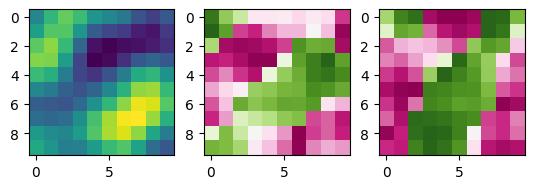

In [6]:
ground = make_ground()
normals = make_normals(ground)
plt.subplot(131)
plt.imshow(ground)
plt.subplot(132)
plt.imshow(normals[:,:,0], "PiYG")
plt.subplot(133)
plt.imshow(normals[:,:,1], "PiYG")

In [7]:
def sample_raytoken(ground, normals):
    (size_x, size_y) = ground.shape
    x_s = np.random.randint(size_x)
    y_s = np.random.randint(size_y)
    height = ground[x_s, y_s]
    normal = normals[x_s, y_s]
    relative_x = (x_s - size_x / 2) * pixel_size
    relative_y = (y_s - size_y / 2) * pixel_size
    th
    return np.array([relative_x, relative_y, height, normal[0], normal[1], normal[2]])

In [8]:
def sample_data(ground, num_samples):
    normals = make_normals(ground)
    samples = np.array([sample_raytoken(ground, normals) for i in range(num_samples)])
    return samples

## The Transformer part

We define a simple transformer model in pytorch and train it on this synthetic data.

In [9]:
class ImageTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, sequence_length, image_size):
        super().__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead),
            num_layers
        )
        self.fc = nn.Linear(d_model * sequence_length, image_size * image_size)
        self.sigmoid = nn.Sigmoid()
        self.sequence_length = sequence_length
        self.image_size = image_size

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Change from (batch_size, seq_len, embedding_size) to (seq_len, batch_size, embedding_size)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Change back to (batch_size, seq_len, embedding_size)
        x = x.reshape(-1, self.sequence_length * x.size(2))
        x = self.fc(x)
        x = x.view(-1, self.image_size, self.image_size)
        return x

In [24]:
# Here, we generate random input data and target images
input_size = 2  # size of each input embedding vector
nhead = 4  # number of attention heads in the transformer
num_layers = 10  # number of transformer layers
d_model = image_size * image_size  # internal model dimension

seq_len = 30  # Number of ray tokens per ground image
num_samples = 1000

# Model
model = ImageTransformer(input_size, d_model, nhead, num_layers, seq_len, image_size)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

In [25]:
def step(model, optimizer, inputs, targets):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Flatten the outputs and targets for the loss calculation
    outputs_flat = outputs.view(-1, image_size * image_size)
    targets_flat = targets.view(-1, image_size * image_size)

    # Calculate loss
    loss = criterion(outputs_flat, targets_flat)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss for monitoring training progress
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

In [26]:
def make_n_blips(n):
    ground = np.zeros((image_size, image_size))
    blips = np.array([[np.random.randint(image_size), np.random.randint(image_size)] for _ in range(n)]).T
    ground[blips[0], blips[1]] = 1.
    blips = blips/image_size - 0.5
    return ground, blips.T

In [30]:
# ground = make_ground()
targets_blips = [make_n_blips(seq_len) for _ in range(num_samples)]
targets, inputs = zip(*targets_blips)
for epoch in range(num_epochs):
    inputs, targets = torch.tensor(np.array(inputs)).float(), torch.tensor(np.array(targets)).float()
    step(model, optimizer, inputs, targets)

Epoch [0/10], Loss: 0.2364
Epoch [1/10], Loss: 0.2421
Epoch [2/10], Loss: 0.2281
Epoch [3/10], Loss: 0.2311
Epoch [4/10], Loss: 0.2348
Epoch [5/10], Loss: 0.2234
Epoch [6/10], Loss: 0.2263
Epoch [7/10], Loss: 0.2299
Epoch [8/10], Loss: 0.2225
Epoch [9/10], Loss: 0.2232


In [23]:
inputs[0]

tensor([[-0.3000,  0.0000],
        [-0.1000, -0.2000],
        [ 0.0000,  0.1000],
        [-0.1000, -0.4000],
        [-0.5000,  0.3000],
        [ 0.1000,  0.0000],
        [ 0.3000,  0.4000],
        [ 0.4000, -0.3000],
        [ 0.1000, -0.2000],
        [ 0.3000, -0.2000],
        [ 0.0000,  0.3000],
        [ 0.2000,  0.0000],
        [ 0.1000, -0.2000],
        [ 0.2000, -0.4000],
        [-0.4000,  0.0000],
        [-0.4000,  0.1000],
        [ 0.1000,  0.2000],
        [-0.4000, -0.2000],
        [-0.3000,  0.3000],
        [ 0.1000, -0.2000],
        [ 0.2000, -0.3000],
        [ 0.2000, -0.3000],
        [-0.1000, -0.3000],
        [ 0.1000,  0.3000],
        [-0.3000, -0.3000],
        [-0.5000,  0.3000],
        [-0.4000, -0.5000],
        [-0.3000,  0.2000],
        [ 0.3000,  0.2000],
        [-0.5000,  0.3000]])

In [14]:
# ground = make_ground()
targets_blips = [make_n_blips(seq_len) for _ in range(num_samples)]
targets = [make_ground() for _ in range(num_samples)]
inputs = [sample_data(ground, seq_len) for ground in targets]
for epoch in range(30):
    inputs, targets = torch.tensor(np.array(inputs)).float(), torch.tensor(np.array(targets)).float()
    step(model, optimizer, inputs, targets)

NameError: name 'th' is not defined

In [ ]:
# for epoch in range(30):
#     targets = [make_ground() for _ in range(num_samples)]
#     inputs = [sample_data(ground, seq_len) for ground in targets]
#     inputs, targets = torch.tensor(np.array(inputs)).float(), torch.tensor(np.array(targets)).float()
#     step(model, optimizer, inputs, targets)

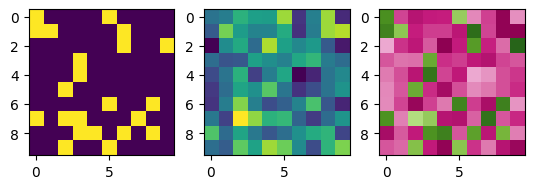

In [32]:
# After training, you can use the model for inference
model.eval()
with torch.no_grad():
    # Example inference with a new input sequence
    # ground = make_ground()
    ground = targets[102]
    # input = sample_data(ground, seq_len)
    # input = torch.tensor(np.array([input])).float()
    input = inputs[102].unsqueeze(0)
    predicted_ground = model(input)

plt.subplot(131)
plt.imshow(ground)
plt.subplot(132)
plt.imshow(predicted_ground[0].numpy())
plt.subplot(133)
plt.imshow(ground - predicted_ground[0].numpy(), "PiYG")